# Database Build for Basic Problems - Main Tables (4 Tables)
### Notebook to Create SQL Database for SQL Tutorial
[Database Located Here](https://sqliteviz.com/app/#/load?data_url=https://storage.googleapis.com/jobs_db/jobs_2023.db&data_format=sqlite&inquiry_url=https://storage.googleapis.com/jobs_db/jobs_2023_inquiries.json)

### Import libraries
NOTE: Used magic command of %%bigquery to execute sql and save to pandas dataframe

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery
pd.set_option('display.max_columns', None)

%load_ext google.cloud.bigquery
# for large datasets store data in google storage for improved speed using the following command
# %bigquery --project job-listings-366015 --use_bqstorage_api 

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [82]:
%%bigquery gsearch_jobs_wide
-- Job posting where salary rate is 'year' and 'hour'
-- filter search_time to 2023-01-01 to 2023-12-31
SELECT *
FROM `job-listings-366015.gsearch_job_listings_clean.gsearch_jobs_wide`
WHERE salary_rate IN ('year', 'hour')
AND search_time BETWEEN '2023-01-01' AND '2024-01-01'


Query is running:   0%|          |

Downloading:   0%|          |

## Drop Duplicates

Dataset size (with Duplicates): 114942
Dataset size (withOut Duplicates): 33585


<AxesSubplot: >

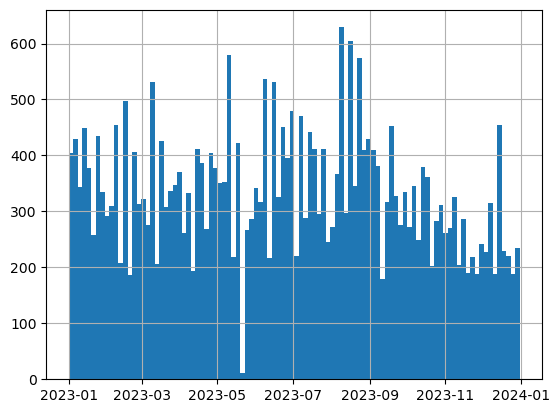

In [83]:
print("Dataset size (with Duplicates):", len(gsearch_jobs_wide))

# Specify the columns to watch
# columns_to_consider = ['job_title_final', 'job_title_clean', 'job_title', 'company_name', 'search_country', 'job_location', 'job_via', 'job_salary', 'job_schedule_type', 'job_work_from_home', 'job_commute_time', 'job_extensions', 'error', 'search_term', 'search_location', 'search_time', 'job_no_degree_mention', 'job_health_insurance', 'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max', 'salary_year', 'salary_hour']
columns_to_consider = ['job_title', 'job_description'] #, 'job_salary']

# Remove duplicates considering only the columns_to_consider
gsearch_jobs_wide = gsearch_jobs_wide.drop_duplicates(subset=columns_to_consider)

print("Dataset size (withOut Duplicates):", len(gsearch_jobs_wide))

# analyze the search_time column, displaying it as a histogram
gsearch_jobs_wide['search_time'].hist(bins=100)

## Drop Unnecessary Columns

In [84]:
gsearch_jobs_wide.head()

columns_to_drop = ["job_title_clean", "job_id", "job_posted_at", "search_term", "search_id", "salary_min", "salary_max", "salary_avg"]

# drop columns
job_postings_fact = gsearch_jobs_wide.drop(columns=columns_to_drop)

# create a job_id column
job_postings_fact["job_id"] = job_postings_fact.index

# reorder columns with job_id first
job_postings_fact = job_postings_fact.set_index('job_id').reset_index()

job_postings_fact.head()

,job_id,job_title_final,job_title,company_name,job_location,job_via,job_description,job_highlights_qualifications,job_highlights_responsibilities,job_highlights_benefits,job_salary,job_schedule_type,job_work_from_home,job_commute_time,job_extensions,company_link,company_link_google,company_thumbnail,error,search_location,search_time,job_no_degree_mention,job_health_insurance,keywords_programming,keywords_databases,keywords_cloud,keywords_libraries,keywords_webframeworks,keywords_os,keywords_analyst_tools,keywords_other,keywords_async,keywords_sync,keywords_all,search_country,salary_pay,salary_rate,salary_year,salary_hour
0,0,Machine Learning Engineer,Machine Learning Engineer,Mutt Data,Argentina,via Ai-Jobs.net,Would you like to be part of a Data Products a...,None,None,None,"74,000–128,058 a year",Full-time,<NA>,None,"[22 hours ago, 74,000–128,058 a year, Full-time]",None,https://www.google.com/search?q=Mutt+Data&sa=X...,https://encrypted-tbn0.gstatic.com/images?q=tb...,False,Argentina,2023-06-17 07:06:55,<NA>,<NA>,{'list': [{'element': 'python'}]},{'list': [{'element': 'postgresql'}]},"{'list': [{'element': 'databricks'}, {'element...","{'list': [{'element': 'spark'}, {'element': 'a...",None,None,None,"{'list': [{'element': 'kubernetes'}, {'element...",None,None,"{'list': [{'element': 'spark'}, {'element': 'a...",Argentina,74000–128058,year,101029.0,NaN
1,1,Data Engineer,Data Center Engineer,Technical Global Solutions,"Sydney NSW, Australia",via LinkedIn,Job: Data Centre Engineer\n\nLocation: Sydney\...,None,None,None,80K–85K a year,Full-time,<NA>,None,"[20 hours ago, 80K–85K a year, Full-time]",None,https://www.google.com/search?hl=en&gl=us&q=Te...,None,False,Australia,2023-04-27 06:19:39,<NA>,<NA>,None,None,None,None,None,None,None,None,None,None,None,Australia,80K–85K,year,82500.0,NaN
2,2,Data Analyst,Business Data Analyst,Air Liquide,Belgium,via Ai-Jobs.net,The Business Data Analyst reports to the Sales...,None,None,None,"30,000–79,976 a year",Full-time,<NA>,None,"[17 hours ago, 30,000–79,976 a year, Full-time]",http://www.airliquide.com/,https://www.google.com/search?sca_esv=58077437...,None,False,Belgium,2023-11-09 06:54:44,<NA>,<NA>,None,None,None,None,{'list': [{'element': 'express'}]},None,"{'list': [{'element': 'power bi'}, {'element':...",None,None,None,"{'list': [{'element': 'power bi'}, {'element':...",Belgium,30000–79976,year,54988.0,NaN
3,3,Data Scientist,Data Scientist,Devoteam,"Zaventem, Belgium",via Ai-Jobs.net,Company DescriptionAbout Devoteam Devoteam is ...,None,None,None,129K–186K a year,Full-time,<NA>,None,"[18 hours ago, 129K–186K a year, Full-time]",None,https://www.google.com/search?hl=en&gl=us&q=De...,None,False,Belgium,2023-07-22 06:56:52,<NA>,<NA>,{'list': [{'element': 'python'}]},None,{'list': [{'element': 'aws'}]},"{'list': [{'element': 'pandas'}, {'element': '...",None,None,None,None,None,None,"{'list': [{'element': 'aws'}, {'element': 'pyt...",Belgium,129K–186K,year,157500.0,NaN
4,4,Data Scientist,Data Scientist Job at Belgium,The Elite Job,Anywhere,via The Elite Job,The Elite Job is a leading company in the hear...,None,None,None,20–30 an hour,Full-time and Part-time,True,None,"[6 hours ago, 20–30 an hour, Work from home, F...",None,https://www.google.com/search?sca_esv=59301625...,None,False,Belgium,2023-12-22 06:29:12,<NA>,<NA>,"{'list': [{'element': 'python'}, {'element': '...",None,"{'list': [{'element': 'aws'}, {'element': 'azu...","{'list': [{'element': 'pandas'}, {'element': '...",None,None,{'list': [{'element': 'tableau'}]},None,None,None,"{'list': [{'element': 'python'}, {'element': '...",Belgium,20–30,hour,NaN,25.0


## Cleanup Job Table

In [85]:
columns_renamed = {
    "search_country": "job_country",
    "salary_year": "salary_year_avg",
    "salary_hour": "salary_hour_avg",
    "search_time": "job_posted_date"
}

# rename columns of job_posting_fact
job_postings_fact = job_postings_fact.rename(columns=columns_renamed)

# convert job_posted_date to a date only object vice date_time
job_postings_fact['job_posted_date'] = job_postings_fact['job_posted_date'].dt.date

# convert job_posted_date to a datetime (needed to upload to bigquery)
job_postings_fact['job_posted_date'] = pd.to_datetime(job_postings_fact['job_posted_date'])


In [86]:
job_postings_fact.head()

,job_id,job_title_final,job_title,company_name,job_location,job_via,job_description,job_highlights_qualifications,job_highlights_responsibilities,job_highlights_benefits,job_salary,job_schedule_type,job_work_from_home,job_commute_time,job_extensions,company_link,company_link_google,company_thumbnail,error,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,keywords_programming,keywords_databases,keywords_cloud,keywords_libraries,keywords_webframeworks,keywords_os,keywords_analyst_tools,keywords_other,keywords_async,keywords_sync,keywords_all,job_country,salary_pay,salary_rate,salary_year_avg,salary_hour_avg
0,0,Machine Learning Engineer,Machine Learning Engineer,Mutt Data,Argentina,via Ai-Jobs.net,Would you like to be part of a Data Products a...,None,None,None,"74,000–128,058 a year",Full-time,<NA>,None,"[22 hours ago, 74,000–128,058 a year, Full-time]",None,https://www.google.com/search?q=Mutt+Data&sa=X...,https://encrypted-tbn0.gstatic.com/images?q=tb...,False,Argentina,2023-06-17,<NA>,<NA>,{'list': [{'element': 'python'}]},{'list': [{'element': 'postgresql'}]},"{'list': [{'element': 'databricks'}, {'element...","{'list': [{'element': 'spark'}, {'element': 'a...",None,None,None,"{'list': [{'element': 'kubernetes'}, {'element...",None,None,"{'list': [{'element': 'spark'}, {'element': 'a...",Argentina,74000–128058,year,101029.0,NaN
1,1,Data Engineer,Data Center Engineer,Technical Global Solutions,"Sydney NSW, Australia",via LinkedIn,Job: Data Centre Engineer\n\nLocation: Sydney\...,None,None,None,80K–85K a year,Full-time,<NA>,None,"[20 hours ago, 80K–85K a year, Full-time]",None,https://www.google.com/search?hl=en&gl=us&q=Te...,None,False,Australia,2023-04-27,<NA>,<NA>,None,None,None,None,None,None,None,None,None,None,None,Australia,80K–85K,year,82500.0,NaN
2,2,Data Analyst,Business Data Analyst,Air Liquide,Belgium,via Ai-Jobs.net,The Business Data Analyst reports to the Sales...,None,None,None,"30,000–79,976 a year",Full-time,<NA>,None,"[17 hours ago, 30,000–79,976 a year, Full-time]",http://www.airliquide.com/,https://www.google.com/search?sca_esv=58077437...,None,False,Belgium,2023-11-09,<NA>,<NA>,None,None,None,None,{'list': [{'element': 'express'}]},None,"{'list': [{'element': 'power bi'}, {'element':...",None,None,None,"{'list': [{'element': 'power bi'}, {'element':...",Belgium,30000–79976,year,54988.0,NaN
3,3,Data Scientist,Data Scientist,Devoteam,"Zaventem, Belgium",via Ai-Jobs.net,Company DescriptionAbout Devoteam Devoteam is ...,None,None,None,129K–186K a year,Full-time,<NA>,None,"[18 hours ago, 129K–186K a year, Full-time]",None,https://www.google.com/search?hl=en&gl=us&q=De...,None,False,Belgium,2023-07-22,<NA>,<NA>,{'list': [{'element': 'python'}]},None,{'list': [{'element': 'aws'}]},"{'list': [{'element': 'pandas'}, {'element': '...",None,None,None,None,None,None,"{'list': [{'element': 'aws'}, {'element': 'pyt...",Belgium,129K–186K,year,157500.0,NaN
4,4,Data Scientist,Data Scientist Job at Belgium,The Elite Job,Anywhere,via The Elite Job,The Elite Job is a leading company in the hear...,None,None,None,20–30 an hour,Full-time and Part-time,True,None,"[6 hours ago, 20–30 an hour, Work from home, F...",None,https://www.google.com/search?sca_esv=59301625...,None,False,Belgium,2023-12-22,<NA>,<NA>,"{'list': [{'element': 'python'}, {'element': '...",None,"{'list': [{'element': 'aws'}, {'element': 'azu...","{'list': [{'element': 'pandas'}, {'element': '...",None,None,{'list': [{'element': 'tableau'}]},None,None,None,"{'list': [{'element': 'python'}, {'element': '...",Belgium,20–30,hour,NaN,25.0


## Create Company Table

In [87]:
company_dim = job_postings_fact

# keep only columns that start with company
company_dim = company_dim.filter(regex='^company', axis=1)

# save column names into a list
col_names_company = company_dim.columns.tolist()

# drop duplicates based on company_name
company_dim = company_dim.drop_duplicates(subset=['company_name'])

# remove company_ from beginning of column names
company_dim.columns = company_dim.columns.str.replace('company_', '')

# create company_id column  and set as index
company_dim['company_id'] = company_dim.index

# make company_id the first column
company_dim = company_dim.set_index('company_id').reset_index()

# company_dim.to_csv('SQL_Database_Build/company_dim.csv', index=False)

company_dim.head()

,company_id,name,link,link_google,thumbnail
0,0,Mutt Data,None,https://www.google.com/search?q=Mutt+Data&sa=X...,https://encrypted-tbn0.gstatic.com/images?q=tb...
1,1,Technical Global Solutions,None,https://www.google.com/search?hl=en&gl=us&q=Te...,None
2,2,Air Liquide,http://www.airliquide.com/,https://www.google.com/search?sca_esv=58077437...,None
3,3,Devoteam,None,https://www.google.com/search?hl=en&gl=us&q=De...,None
4,4,The Elite Job,None,https://www.google.com/search?sca_esv=59301625...,None


## Cleanup Company Info in fact table


In [88]:
# merge on company_id only on to job_postings_fact from company_dim
job_postings_fact = pd.merge(job_postings_fact, company_dim[['company_id', 'name']],left_on='company_name', right_on='name', how='left')

# drop column names that start with 'name' or are in the list col_names_company
job_postings_fact = job_postings_fact.drop(columns=col_names_company)
job_postings_fact = job_postings_fact.drop(columns=['name'])

job_postings_fact.head()

,job_id,job_title_final,job_title,job_location,job_via,job_description,job_highlights_qualifications,job_highlights_responsibilities,job_highlights_benefits,job_salary,job_schedule_type,job_work_from_home,job_commute_time,job_extensions,error,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,keywords_programming,keywords_databases,keywords_cloud,keywords_libraries,keywords_webframeworks,keywords_os,keywords_analyst_tools,keywords_other,keywords_async,keywords_sync,keywords_all,job_country,salary_pay,salary_rate,salary_year_avg,salary_hour_avg,company_id
0,0,Machine Learning Engineer,Machine Learning Engineer,Argentina,via Ai-Jobs.net,Would you like to be part of a Data Products a...,None,None,None,"74,000–128,058 a year",Full-time,<NA>,None,"[22 hours ago, 74,000–128,058 a year, Full-time]",False,Argentina,2023-06-17,<NA>,<NA>,{'list': [{'element': 'python'}]},{'list': [{'element': 'postgresql'}]},"{'list': [{'element': 'databricks'}, {'element...","{'list': [{'element': 'spark'}, {'element': 'a...",None,None,None,"{'list': [{'element': 'kubernetes'}, {'element...",None,None,"{'list': [{'element': 'spark'}, {'element': 'a...",Argentina,74000–128058,year,101029.0,NaN,0
1,1,Data Engineer,Data Center Engineer,"Sydney NSW, Australia",via LinkedIn,Job: Data Centre Engineer\n\nLocation: Sydney\...,None,None,None,80K–85K a year,Full-time,<NA>,None,"[20 hours ago, 80K–85K a year, Full-time]",False,Australia,2023-04-27,<NA>,<NA>,None,None,None,None,None,None,None,None,None,None,None,Australia,80K–85K,year,82500.0,NaN,1
2,2,Data Analyst,Business Data Analyst,Belgium,via Ai-Jobs.net,The Business Data Analyst reports to the Sales...,None,None,None,"30,000–79,976 a year",Full-time,<NA>,None,"[17 hours ago, 30,000–79,976 a year, Full-time]",False,Belgium,2023-11-09,<NA>,<NA>,None,None,None,None,{'list': [{'element': 'express'}]},None,"{'list': [{'element': 'power bi'}, {'element':...",None,None,None,"{'list': [{'element': 'power bi'}, {'element':...",Belgium,30000–79976,year,54988.0,NaN,2
3,3,Data Scientist,Data Scientist,"Zaventem, Belgium",via Ai-Jobs.net,Company DescriptionAbout Devoteam Devoteam is ...,None,None,None,129K–186K a year,Full-time,<NA>,None,"[18 hours ago, 129K–186K a year, Full-time]",False,Belgium,2023-07-22,<NA>,<NA>,{'list': [{'element': 'python'}]},None,{'list': [{'element': 'aws'}]},"{'list': [{'element': 'pandas'}, {'element': '...",None,None,None,None,None,None,"{'list': [{'element': 'aws'}, {'element': 'pyt...",Belgium,129K–186K,year,157500.0,NaN,3
4,4,Data Scientist,Data Scientist Job at Belgium,Anywhere,via The Elite Job,The Elite Job is a leading company in the hear...,None,None,None,20–30 an hour,Full-time and Part-time,True,None,"[6 hours ago, 20–30 an hour, Work from home, F...",False,Belgium,2023-12-22,<NA>,<NA>,"{'list': [{'element': 'python'}, {'element': '...",None,"{'list': [{'element': 'aws'}, {'element': 'azu...","{'list': [{'element': 'pandas'}, {'element': '...",None,None,{'list': [{'element': 'tableau'}]},None,None,None,"{'list': [{'element': 'python'}, {'element': '...",Belgium,20–30,hour,NaN,25.0,4


## Skills to Job Table

In [89]:
skills_job_dim = job_postings_fact

# keep only columns that start with 'keyords_' and 'job_id'
skills_job_dim = skills_job_dim.filter(regex='^keywords_|job_id', axis=1)

#remove keywords_ from beginning of column names
skills_job_dim.columns = skills_job_dim.columns.str.replace('keywords_', '')

# drop the 'all' column
skills_job_dim = skills_job_dim.drop(columns=['all'])

# unpivot the dataframe keeping the job_id column
skills_job_dim = skills_job_dim.melt(id_vars=['job_id'], var_name='type', value_name='skills')

# drop None values in skills column
skills_job_dim = skills_job_dim.dropna(subset=['skills'])

# First, transform the 'skills' column into a list of elements
skills_job_dim['skills'] = skills_job_dim['skills'].apply(lambda x: [item['element'] for item in x['list']])

# Then, use explode to create a new row for each element in the lists
skills_job_dim = skills_job_dim.explode('skills')

skills_job_dim

,job_id,type,skills
0,0,programming,python
3,3,programming,python
4,4,programming,python
4,4,programming,r
6,6,programming,python
...,...,...,...
335626,113322,sync,twilio
335760,114316,sync,slack
335760,114316,sync,zoom
335766,114356,sync,microsoft teams


## Skill Table

In [90]:
skills_dim = skills_job_dim[['skills', 'type']].drop_duplicates().reset_index(drop=True).reset_index()
skills_dim.columns = ['skill_id', 'skills', 'type']

# skills_dim.to_csv('SQL_Database_Build/skills_dim.csv', index=False)

skills_dim

,skill_id,skills,type
0,0,python,programming
1,1,r,programming
2,2,sql,programming
3,3,scala,programming
4,4,java,programming
...,...,...,...
220,220,wire,sync
221,221,twilio,sync
222,222,ringcentral,sync
223,223,symphony,sync


## Skill to Job Table - Add Skill ID and remove skill

In [91]:
skills_job_dim = pd.merge(skills_job_dim, skills_dim[['skill_id', 'skills']], on=['skills'], how='left')

skills_job_dim = skills_job_dim[['job_id', 'skill_id']]

# skills_job_dim.to_csv('SQL_Database_Build/skills_job_dim.csv', index=False)

skills_job_dim

,job_id,skill_id
0,0,0
1,3,0
2,4,0
3,4,1
4,6,0
...,...,...
179538,113322,221
179539,114316,217
179540,114316,218
179541,114356,219


In [92]:
job_postings_fact = job_postings_fact.drop(columns=['job_description', 'job_highlights_qualifications', 'job_highlights_responsibilities', 'job_highlights_benefits' , 'job_salary', 'job_commute_time', 'job_extensions', 'error', 'salary_pay'])

#remove columns that start with "keywords_"
job_postings_fact = job_postings_fact.filter(regex='^(?!keywords_)', axis=1)

# rename column job_title_final to job_title_simple
job_postings_fact = job_postings_fact.rename(columns={'job_title_final': 'job_title_short'})

# replace '<NA>' values with False in job_work_from_home, job_no_degree_mention, and job_health_insurance columns
job_postings_fact['job_work_from_home'] = job_postings_fact['job_work_from_home'].fillna(False)
job_postings_fact['job_no_degree_mention'] = job_postings_fact['job_no_degree_mention'].fillna(False)
job_postings_fact['job_health_insurance'] = job_postings_fact['job_health_insurance'].fillna(False)

# move company_id column to the right after job_id
cols = list(job_postings_fact.columns.values)
cols.pop(cols.index('company_id'))
job_postings_fact = job_postings_fact[['company_id']+ cols]

# set job_id as index
job_postings_fact = job_postings_fact.set_index('job_id').reset_index()

job_postings_fact

# job_postings_fact.to_csv('SQL_Database_Build/job_postings_fact.csv', index=False)

,job_id,company_id,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg
0,0,0,Machine Learning Engineer,Machine Learning Engineer,Argentina,via Ai-Jobs.net,Full-time,False,Argentina,2023-06-17,False,False,Argentina,year,101029.0,NaN
1,1,1,Data Engineer,Data Center Engineer,"Sydney NSW, Australia",via LinkedIn,Full-time,False,Australia,2023-04-27,False,False,Australia,year,82500.0,NaN
2,2,2,Data Analyst,Business Data Analyst,Belgium,via Ai-Jobs.net,Full-time,False,Belgium,2023-11-09,False,False,Belgium,year,54988.0,NaN
3,3,3,Data Scientist,Data Scientist,"Zaventem, Belgium",via Ai-Jobs.net,Full-time,False,Belgium,2023-07-22,False,False,Belgium,year,157500.0,NaN
4,4,4,Data Scientist,Data Scientist Job at Belgium,Anywhere,via The Elite Job,Full-time and Part-time,True,Belgium,2023-12-22,False,False,Belgium,hour,NaN,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33580,114920,5194,Data Scientist,People Analyst,"Westlake, TX",via Adzuna,Full-time,False,"Texas, United States",2023-02-14,False,False,United States,year,111000.0,NaN
33581,114933,33581,Data Analyst,Sourcing Analyst,"Fort Worth, TX",via My ArkLaMiss Jobs,Full-time,False,"Texas, United States",2023-02-19,True,True,United States,year,90000.0,NaN
33582,114936,22894,Data Scientist,Data Science Team Lead,"İstanbul, Türkiye",via Ai-Jobs.net,Full-time,False,Turkey,2023-06-15,False,False,Turkey,year,79200.0,NaN
33583,114938,33583,Data Analyst,Data Analyst,"Manchester, UK",via Ai-Jobs.net,Full-time,False,United Kingdom,2023-07-07,False,False,United Kingdom,year,100500.0,NaN


## Add tables to BigQuery

In [93]:
import pandas as pd
from pandas_gbq import to_gbq

to_gbq(job_postings_fact, 'sql_tutorial_jobs.job_postings_fact', project_id='job-listings-366015', if_exists='replace')
to_gbq(company_dim, 'sql_tutorial_jobs.company_dim', project_id='job-listings-366015', if_exists='replace')
to_gbq(skills_dim, 'sql_tutorial_jobs.skills_dim', project_id='job-listings-366015', if_exists='replace')
to_gbq(skills_job_dim, 'sql_tutorial_jobs.skills_job_dim', project_id='job-listings-366015', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


## Create .db file (SQLite)

In [94]:
import sqlite3
import subprocess

# Connect to the database (or create it if it doesn't exist)
conn = sqlite3.connect('jobs_2023.db')

# Create the tables in the database using the four main dataframes
job_postings_fact.to_sql('job_postings_fact', conn, if_exists='replace', index=False)
company_dim.to_sql('company_dim', conn, if_exists='replace', index=False)
skills_dim.to_sql('skills_dim', conn, if_exists='replace', index=False)
skills_job_dim.to_sql('skills_job_dim', conn, if_exists='replace', index=False)

# Close the connection
conn.close()

# had to update google cloud bucket on where storing sql file to allow CORS access
# gcloud storage buckets update gs://jobs_db --cors-file=delete.json

# delete.json file
# [
#     {
#       "origin": ["https://your-example-website.appspot.com"],
#       "method": ["GET"],
#       "responseHeader": ["Content-Type"],
#       "maxAgeSeconds": 3600
#     }
# ]